# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [ ]:
import torch
try:
    # Get GPU name, check if it's K80
    GPU_name = torch.cuda.get_device_name()
    if GPU_name[-3:] == "K80":
        print("Get K80! :'( RESTART!")
        exit()  # Restart the session
    else:
        print("Your GPU is {}!".format(GPU_name))
        print("Great! Keep going~")
except RuntimeError as e:
    if e.args == ("No CUDA GPUs are available",):
        print("You are training with CPU! "
              "Please restart!")
        exit()  # Restart the session
    else:
        print("What's wrong here?")
        print("Error message: \n", e)

Your GPU is Tesla P100-PCIE-16GB!
Great! Keep going~


In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

Requirement already up-to-date: jupyter in /usr/local/lib/python3.7/dist-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.7/dist-packages (7.6.3)


In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp37-cp37m-linux_x86_64.whl size=2817635 sha256=b366ef62a6a548d866ac27196a22e0015cf62c4ba1e19ba99024be2cea2fd602
  Stored in directory: /tmp/pip-ephem-wheel-cache-uur_68nt/wheels/94/b2/67/6399f5bcb823dc3a8b1e84965aaae15af9ed863fee98a59129
Successfully built fairseq
  Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [ ]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [ ]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## 設定語言(fixed)

In [ ]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [ ]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/content/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/content/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [ ]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/content/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/content/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !


## 用 fairseq 將資料轉為 binary

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# 實驗的參數設定表
### With Back Translation src = 'zh'/ tgt = 'en'

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn-back",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=20,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)


# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-30 09:41:26 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-30 09:41:26 | INFO | fairseq.utils | rank   0: capabilities =  6.0  ; total memory = 15.899 GB ; name = Tesla P100-PCIE-16GB                    
2021-04-30 09:41:26 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-30 09:41:26 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-30 09:41:26 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-30 09:41:26 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-30 09:41:26 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-04-30 09:41:26 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-04-30 09:41:26 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-04-30 09:41:26 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-04-30 09:41:26 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-04-30 09:41:26 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2]),
 'target': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-30 09:41:26 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 1062, 527, 2861, 2415, 1633, 1624, 2626, 210, 880]


{'id': tensor([3517]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,
            188,    4,   33,    4,   32,    1,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([13]),
  'src_tokens': tensor([[   1,    1,    1,    4, 1259, 2926,  157, 3552, 1591,  137,  162, 1173,
            434,    4,   33,    2]])},
 'nsentences': 1,
 'ntokens': 17,
 'target': tensor([[   4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,  188,
             4,   33,    4,   32,    2,    1,    1,    1,    1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [ ]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [ ]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [ ]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [ ]:
# # HINT: transformer 架構
from fairseq.models.transformer import (TransformerEncoder, TransformerDecoder,)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=1024,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=1024,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
  
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
  
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
  
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-30 09:41:28 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=512, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

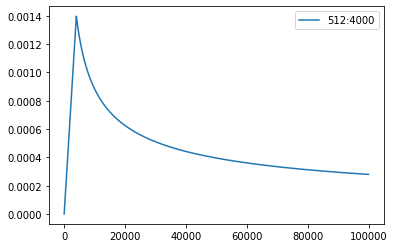

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [ ]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [ ]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 預測函式

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Back-translation

# 主程式
## 訓練迴圈

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
!nvidia-smi

Fri Apr 30 09:41:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    37W / 250W |   5913MiB / 16280MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-30 09:41:29 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-30 09:41:29 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-30 09:41:29 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-30 09:41:29 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-30 09:41:29 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-30 09:41:29 | INFO | hw5.seq2seq | num. model params: 39,737,344 (num. trained: 39,737,344)
2021-04-30 09:41:29 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-30 09:41:29 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-30 09:41:29 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn-back/checkpoint_last.pt!


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc04c958ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc04c958ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-30 09:53:42 | INFO | hw5.seq2seq | training loss: 5.6033
2021-04-30 09:53:42 | INFO | hw5.seq2seq | begin validation


2021-04-30 09:54:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 09:54:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 09:54:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 09:54:34 | INFO | hw5.seq2seq | example source: 而且我們也知道 , 我們在失去二氧化碳 。
2021-04-30 09:54:34 | INFO | hw5.seq2seq | example hypothesis: and we also know , we know , we're oxed in oxide .
2021-04-30 09:54:34 | INFO | hw5.seq2seq | example reference: and we knew that we were losing co2 .
2021-04-30 09:54:34 | INFO | hw5.seq2seq | validation loss:	4.2665
2021-04-30 09:54:34 | INFO | hw5.seq2seq | BLEU = 3.49 25.9/6.2/1.8/0.5 (BP = 1.000 ratio = 1.159 hyp_len = 89284 ref_len = 77050)
2021-04-30 09:54:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint1.pt
2021-04-30 09:54:35 | INFO

2021-04-30 10:06:49 | INFO | hw5.seq2seq | training loss: 3.8278
2021-04-30 10:06:49 | INFO | hw5.seq2seq | begin validation


2021-04-30 10:07:30 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 10:07:30 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 10:07:30 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 10:07:31 | INFO | hw5.seq2seq | example source: 不過就是意識嘛 。 」
2021-04-30 10:07:31 | INFO | hw5.seq2seq | example hypothesis: but it's conscious . "
2021-04-30 10:07:31 | INFO | hw5.seq2seq | example reference: well , consciousness . "
2021-04-30 10:07:31 | INFO | hw5.seq2seq | validation loss:	3.3921
2021-04-30 10:07:31 | INFO | hw5.seq2seq | BLEU = 8.53 50.0/18.6/8.3/3.9 (BP = 0.646 ratio = 0.696 hyp_len = 53639 ref_len = 77050)
2021-04-30 10:07:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint2.pt
2021-04-30 10:07:32 | INFO | hw5.seq2seq | end of epoch 2


2021-04-30 10:19:48 | INFO | hw5.seq2seq | training loss: 3.2753
2021-04-30 10:19:48 | INFO | hw5.seq2seq | begin validation


2021-04-30 10:20:34 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 10:20:34 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 10:20:34 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 10:20:36 | INFO | hw5.seq2seq | example source: 你以為自己有幾斤幾兩 ?
2021-04-30 10:20:36 | INFO | hw5.seq2seq | example hypothesis: do you think you have two kilograms ?
2021-04-30 10:20:36 | INFO | hw5.seq2seq | example reference: who do you think you are ?
2021-04-30 10:20:36 | INFO | hw5.seq2seq | validation loss:	3.0755
2021-04-30 10:20:36 | INFO | hw5.seq2seq | BLEU = 12.55 47.7/19.5/9.3/4.6 (BP = 0.892 ratio = 0.897 hyp_len = 69114 ref_len = 77050)
2021-04-30 10:20:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint3.pt
2021-04-30 10:20:37 | INFO | hw5.seq2seq | end of epoch 3

2021-04-30 10:32:51 | INFO | hw5.seq2seq | training loss: 3.0478
2021-04-30 10:32:51 | INFO | hw5.seq2seq | begin validation


2021-04-30 10:33:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 10:33:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 10:33:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 10:33:37 | INFO | hw5.seq2seq | example source: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2021-04-30 10:33:37 | INFO | hw5.seq2seq | example hypothesis: in the help of modern science , cotton is probably going to be faster than the past and flexible , because researchers are based on nutrition , climate conditions , and genetics , and genetics , explore the optimization of how cotton does its biology .
2021-04-30 10:33:37 | INFO | hw5.seq2seq | example reference: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever 

2021-04-30 10:45:52 | INFO | hw5.seq2seq | training loss: 2.9285
2021-04-30 10:45:52 | INFO | hw5.seq2seq | begin validation


2021-04-30 10:46:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 10:46:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 10:46:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 10:46:40 | INFO | hw5.seq2seq | example source: 隨著油價上漲 , 能源專利也愈多 。
2021-04-30 10:46:40 | INFO | hw5.seq2seq | example hypothesis: as oil prices are rising , more energy patents are also more energy patents .
2021-04-30 10:46:40 | INFO | hw5.seq2seq | example reference: as oil prices go up , energy patents go up .
2021-04-30 10:46:40 | INFO | hw5.seq2seq | validation loss:	2.8937
2021-04-30 10:46:40 | INFO | hw5.seq2seq | BLEU = 15.15 47.0/20.4/10.3/5.3 (BP = 1.000 ratio = 1.005 hyp_len = 77449 ref_len = 77050)
2021-04-30 10:46:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpo

2021-04-30 10:58:57 | INFO | hw5.seq2seq | training loss: 2.8207
2021-04-30 10:58:57 | INFO | hw5.seq2seq | begin validation


2021-04-30 10:59:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 10:59:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 10:59:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 10:59:45 | INFO | hw5.seq2seq | example source: 讓我們多想想資料
2021-04-30 10:59:45 | INFO | hw5.seq2seq | example hypothesis: let's think about the data .
2021-04-30 10:59:45 | INFO | hw5.seq2seq | example reference: let's think about data for a bit .
2021-04-30 10:59:45 | INFO | hw5.seq2seq | validation loss:	2.7660
2021-04-30 10:59:45 | INFO | hw5.seq2seq | BLEU = 17.03 54.7/25.5/13.5/7.4 (BP = 0.883 ratio = 0.889 hyp_len = 68512 ref_len = 77050)
2021-04-30 10:59:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint6.pt
2021-04-30 10:59:46 | INFO | hw5.seq2seq | end of epoch 6


2021-04-30 11:12:04 | INFO | hw5.seq2seq | training loss: 2.7052
2021-04-30 11:12:04 | INFO | hw5.seq2seq | begin validation


2021-04-30 11:12:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 11:12:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 11:12:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 11:12:51 | INFO | hw5.seq2seq | example source: 所以我們也當如此
2021-04-30 11:12:51 | INFO | hw5.seq2seq | example hypothesis: so we did .
2021-04-30 11:12:51 | INFO | hw5.seq2seq | example reference: and so it should be with us .
2021-04-30 11:12:51 | INFO | hw5.seq2seq | validation loss:	2.6982
2021-04-30 11:12:51 | INFO | hw5.seq2seq | BLEU = 17.76 55.9/26.5/14.4/8.1 (BP = 0.870 ratio = 0.877 hyp_len = 67601 ref_len = 77050)
2021-04-30 11:12:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint7.pt
2021-04-30 11:12:53 | INFO | hw5.seq2seq | end of epoch 7


2021-04-30 11:25:11 | INFO | hw5.seq2seq | training loss: 2.6195
2021-04-30 11:25:11 | INFO | hw5.seq2seq | begin validation


2021-04-30 11:25:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 11:25:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 11:25:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 11:25:59 | INFO | hw5.seq2seq | example source: 噢 , 好 , 好了 ! 你們都別再打了 !
2021-04-30 11:25:59 | INFO | hw5.seq2seq | example hypothesis: oh , okay , you're not going to hit it again .
2021-04-30 11:25:59 | INFO | hw5.seq2seq | example reference: oh great ! yeah . yeah you can all stop calling now !
2021-04-30 11:25:59 | INFO | hw5.seq2seq | validation loss:	2.6400
2021-04-30 11:25:59 | INFO | hw5.seq2seq | BLEU = 18.53 55.3/26.6/14.4/8.1 (BP = 0.909 ratio = 0.913 hyp_len = 70323 ref_len = 77050)
2021-04-30 11:26:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint8.pt
2021-04-30

2021-04-30 11:38:19 | INFO | hw5.seq2seq | training loss: 2.5525
2021-04-30 11:38:19 | INFO | hw5.seq2seq | begin validation


2021-04-30 11:39:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 11:39:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 11:39:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 11:39:07 | INFO | hw5.seq2seq | example source: 第三點:團結盟友 。
2021-04-30 11:39:07 | INFO | hw5.seq2seq | example hypothesis: number three: solidarity allies .
2021-04-30 11:39:07 | INFO | hw5.seq2seq | example reference: number three: rally your allies .
2021-04-30 11:39:07 | INFO | hw5.seq2seq | validation loss:	2.6184
2021-04-30 11:39:07 | INFO | hw5.seq2seq | BLEU = 19.57 54.7/26.5/14.6/8.3 (BP = 0.956 ratio = 0.957 hyp_len = 73759 ref_len = 77050)
2021-04-30 11:39:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint9.pt
2021-04-30 11:39:08 | INFO | hw5.seq2seq | end of epoch

2021-04-30 11:51:27 | INFO | hw5.seq2seq | training loss: 2.4983
2021-04-30 11:51:27 | INFO | hw5.seq2seq | begin validation


2021-04-30 11:52:13 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 11:52:13 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 11:52:13 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 11:52:15 | INFO | hw5.seq2seq | example source: 但是他教我的把戲永遠跟我在一起 , 讓我可以到處在學校裡 , 試著讓這個世界變得更好一點 。
2021-04-30 11:52:15 | INFO | hw5.seq2seq | example hypothesis: but he taught me that the trick was always with me , so that i could go to school , trying to make the world a little bit better .
2021-04-30 11:52:15 | INFO | hw5.seq2seq | example reference: but the trick that he showed me stayed with me and enabled me to go around schools and try to make this world just a little bit better .
2021-04-30 11:52:15 | INFO | hw5.seq2seq | validation loss:	2.6057
2021-04-30 11:52:15 | INFO | hw5.seq2seq | BLEU = 19.52 54.1/26.2

2021-04-30 12:04:35 | INFO | hw5.seq2seq | training loss: 2.4547
2021-04-30 12:04:35 | INFO | hw5.seq2seq | begin validation


2021-04-30 12:05:20 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 12:05:20 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 12:05:20 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 12:05:21 | INFO | hw5.seq2seq | example source: 人們因為無法負擔醫藥而十分掙扎 , 甚至因此而死 。
2021-04-30 12:05:21 | INFO | hw5.seq2seq | example hypothesis: people struggled with medicine , and even died because they couldn't afford it .
2021-04-30 12:05:21 | INFO | hw5.seq2seq | example reference: and people are struggling or even dying , because they can't afford the meds .
2021-04-30 12:05:21 | INFO | hw5.seq2seq | validation loss:	2.5876
2021-04-30 12:05:21 | INFO | hw5.seq2seq | BLEU = 19.30 57.7/28.7/16.0/9.2 (BP = 0.869 ratio = 0.877 hyp_len = 67543 ref_len = 77050)
2021-04-30 12:05:22 | INFO | hw5.seq2seq | saved epoch chec

2021-04-30 12:17:39 | INFO | hw5.seq2seq | training loss: 2.4118
2021-04-30 12:17:39 | INFO | hw5.seq2seq | begin validation


2021-04-30 12:18:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 12:18:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 12:18:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 12:18:26 | INFO | hw5.seq2seq | example source: 健康的彌猴就跟健康的人一樣 , 射出分率大約是65% 。
2021-04-30 12:18:26 | INFO | hw5.seq2seq | example hypothesis: a healthy macaque is like a healthy person , about 65 percent ejection rate .
2021-04-30 12:18:26 | INFO | hw5.seq2seq | example reference: now , in healthy macaques , like in healthy people , ejection fractions are about 65 percent .
2021-04-30 12:18:26 | INFO | hw5.seq2seq | validation loss:	2.5765
2021-04-30 12:18:26 | INFO | hw5.seq2seq | BLEU = 19.85 57.1/28.3/15.8/9.1 (BP = 0.903 ratio = 0.908 hyp_len = 69946 ref_len = 77050)
2021-04-30 12:18:26 | INFO | hw5.seq2seq | s

2021-04-30 12:30:44 | INFO | hw5.seq2seq | training loss: 2.3776
2021-04-30 12:30:44 | INFO | hw5.seq2seq | begin validation


2021-04-30 12:31:30 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 12:31:30 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 12:31:30 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 12:31:32 | INFO | hw5.seq2seq | example source: 所以 , 就是這樣 。 第二段 , 你可以真正地直言不諱 , 說說你真正在意的事 。
2021-04-30 12:31:32 | INFO | hw5.seq2seq | example hypothesis: so , that's it . that's the second paragraph , where you can really be outspoken and say what you really care about .
2021-04-30 12:31:32 | INFO | hw5.seq2seq | example reference: so , here you go . paragraph number two: you may actually have to just get very blunt and say what's really on your mind .
2021-04-30 12:31:32 | INFO | hw5.seq2seq | validation loss:	2.5683
2021-04-30 12:31:32 | INFO | hw5.seq2seq | BLEU = 20.53 56.5/28.2/16.0/9.2 (BP = 0.933 ratio = 0

2021-04-30 12:43:53 | INFO | hw5.seq2seq | training loss: 2.3439
2021-04-30 12:43:53 | INFO | hw5.seq2seq | begin validation


2021-04-30 12:44:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 12:44:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 12:44:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 12:44:40 | INFO | hw5.seq2seq | example source: 埃勒夫和他的家人從海珊的伊拉克充做難民逃往紐約 ,
2021-04-30 12:44:40 | INFO | hw5.seq2seq | example hypothesis: elev and his family fled in new york with iraq in seazan .
2021-04-30 12:44:40 | INFO | hw5.seq2seq | example reference: aref and his family fled to new york from saddam hussein's iraq as refugees .
2021-04-30 12:44:40 | INFO | hw5.seq2seq | validation loss:	2.5653
2021-04-30 12:44:40 | INFO | hw5.seq2seq | BLEU = 20.23 56.8/28.3/16.0/9.3 (BP = 0.915 ratio = 0.919 hyp_len = 70783 ref_len = 77050)
2021-04-30 12:44:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpo

2021-04-30 12:56:57 | INFO | hw5.seq2seq | training loss: 2.3159
2021-04-30 12:56:57 | INFO | hw5.seq2seq | begin validation


2021-04-30 12:57:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 12:57:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 12:57:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 12:57:45 | INFO | hw5.seq2seq | example source: 如今在印度 , 信奉印度基本教義的人他們的大型集會看起來就是這個樣子 。
2021-04-30 12:57:45 | INFO | hw5.seq2seq | example hypothesis: today in india , the largest gatherings of the underlying fundamentalist would look like this .
2021-04-30 12:57:45 | INFO | hw5.seq2seq | example reference: this is what the main hindu fundamentalist organization in india looks like today at its mass rally .
2021-04-30 12:57:45 | INFO | hw5.seq2seq | validation loss:	2.5729
2021-04-30 12:57:45 | INFO | hw5.seq2seq | BLEU = 20.17 56.8/28.1/15.7/9.1 (BP = 0.922 ratio = 0.925 hyp_len = 71271 ref_len = 77050)
2021-04-30 

2021-04-30 13:10:04 | INFO | hw5.seq2seq | training loss: 2.2906
2021-04-30 13:10:04 | INFO | hw5.seq2seq | begin validation


2021-04-30 13:10:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 13:10:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 13:10:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 13:10:51 | INFO | hw5.seq2seq | example source: 這也是電腦被發明出來的時間 , 當初有一個模擬人腦的基礎想法是由艾倫·圖靈所提出 , 他稱之為 「 智能機械 」 , 他是計算機科學之父之一 。
2021-04-30 13:10:51 | INFO | hw5.seq2seq | example hypothesis: this is the time that computers were invented , and there was a fundamental idea of the human brain that came up with what alan turing called the intelligent machine , one of the fathers of computer science .
2021-04-30 13:10:51 | INFO | hw5.seq2seq | example reference: this was the very same time when computers were being invented , very much based on the idea of modeling the brain of " intelligent machinery , " as alan turing call

2021-04-30 13:23:12 | INFO | hw5.seq2seq | training loss: 2.2655
2021-04-30 13:23:12 | INFO | hw5.seq2seq | begin validation


2021-04-30 13:23:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 13:23:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 13:23:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 13:24:00 | INFO | hw5.seq2seq | example source: 智慧手機是如此美麗的小機器 。
2021-04-30 13:24:00 | INFO | hw5.seq2seq | example hypothesis: the smartphone is such a beautiful little machine .
2021-04-30 13:24:00 | INFO | hw5.seq2seq | example reference: it's such a beautiful little machine .
2021-04-30 13:24:00 | INFO | hw5.seq2seq | validation loss:	2.5724
2021-04-30 13:24:00 | INFO | hw5.seq2seq | BLEU = 20.58 56.3/28.0/15.8/9.2 (BP = 0.942 ratio = 0.943 hyp_len = 72683 ref_len = 77050)
2021-04-30 13:24:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint17.pt
2021-04-30 13:24:01 | INFO

2021-04-30 13:36:20 | INFO | hw5.seq2seq | training loss: 2.2441
2021-04-30 13:36:20 | INFO | hw5.seq2seq | begin validation


2021-04-30 13:37:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 13:37:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 13:37:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 13:37:08 | INFO | hw5.seq2seq | example source: 它還沒有名字呢 。
2021-04-30 13:37:08 | INFO | hw5.seq2seq | example hypothesis: it doesn't have a name yet .
2021-04-30 13:37:08 | INFO | hw5.seq2seq | example reference: it doesn't have a name yet .
2021-04-30 13:37:08 | INFO | hw5.seq2seq | validation loss:	2.5759
2021-04-30 13:37:08 | INFO | hw5.seq2seq | BLEU = 20.08 56.5/27.9/15.7/9.1 (BP = 0.921 ratio = 0.924 hyp_len = 71182 ref_len = 77050)
2021-04-30 13:37:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-back/checkpoint18.pt
2021-04-30 13:37:09 | INFO | hw5.seq2seq | end of epoch 18


2021-04-30 13:49:28 | INFO | hw5.seq2seq | training loss: 2.2246
2021-04-30 13:49:28 | INFO | hw5.seq2seq | begin validation


2021-04-30 13:50:14 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 13:50:14 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 13:50:14 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 13:50:16 | INFO | hw5.seq2seq | example source: 改變我們基因的方法之一 , 是製造新的基因 , 如同克萊格•凡特之前優雅的演說一般 。
2021-04-30 13:50:16 | INFO | hw5.seq2seq | example hypothesis: one way to change our genes is to make new genes like craig venter's talk .
2021-04-30 13:50:16 | INFO | hw5.seq2seq | example reference: one way to change our genes is to make new ones , as craig venter has so elegantly shown .
2021-04-30 13:50:16 | INFO | hw5.seq2seq | validation loss:	2.5792
2021-04-30 13:50:16 | INFO | hw5.seq2seq | BLEU = 20.68 57.2/28.6/16.3/9.6 (BP = 0.920 ratio = 0.923 hyp_len = 71153 ref_len = 77050)
2021-04-30 13:50:16 | INFO | hw5.se

2021-04-30 14:02:38 | INFO | hw5.seq2seq | training loss: 2.2038
2021-04-30 14:02:38 | INFO | hw5.seq2seq | begin validation


2021-04-30 14:03:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 14:03:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 14:03:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 14:03:26 | INFO | hw5.seq2seq | example source: 所以在接下來的17分半中我要做的是先來談談現在的危機--目前的經濟狀況--讓後我將用三個在ted過去25年裡提到的然後會出現在這個會談裡的趨勢我會試著將它們統整
2021-04-30 14:03:26 | INFO | hw5.seq2seq | example hypothesis: so what i'm going to do in the next 17andahalf parts is i'm going to talk about the current economy where i'm going to take three of those twoandahalf years of ted , and i'm going to show up in this conversation , and i'm going to try to unify them .
2021-04-30 14:03:26 | INFO | hw5.seq2seq | example reference: so what i'm going to try to do in the next 17 and a half minutes is i'm going to talk first about the flames where 

## Submission 繳交檔案

In [ ]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn-back'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn-back/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn-back/checkpoint20.pt', './checkpoints/rnn-back/checkpoint19.pt', './checkpoints/rnn-back/checkpoint18.pt', './checkpoints/rnn-back/checkpoint17.pt', './checkpoints/rnn-back/checkpoint16.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn-back/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [ ]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-30 14:03:30 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn-back/avg_last_5_checkpoint.pt: step=unknown loss=2.581270694732666 bleu=20.425540132233255
2021-04-30 14:03:30 | INFO | hw5.seq2seq | begin validation


2021-04-30 14:04:16 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-30 14:04:16 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-30 14:04:16 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-30 14:04:18 | INFO | hw5.seq2seq | example source: 這就像是摧毀一整個城市或森林一樣 , 一掃而空 ,
2021-04-30 14:04:18 | INFO | hw5.seq2seq | example hypothesis: it's like destroying a city or a forest .
2021-04-30 14:04:18 | INFO | hw5.seq2seq | example reference: think of it as being kind of the bulldozing of a city or of a forest , because it clears it away .
2021-04-30 14:04:18 | INFO | hw5.seq2seq | validation loss:	2.5380
2021-04-30 14:04:18 | INFO | hw5.seq2seq | BLEU = 21.15 57.6/29.2/16.7/9.8 (BP = 0.923 ratio = 0.926 hyp_len = 71315 ref_len = 77050)


## 利用反向模型生成額外資料

### 下載 monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

--2021-04-30 14:04:18--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zla8og.dm.files.1drv.com/y4mgnW-KKRM-Sov89HTgV1zz_C50ZrUPLMOXMscobD8unphyscQIUOv9ORY5UvBFNZIjP0x7PuGe5ysS9rVZWWo_NjmpVGRMVvsFp1w7QGjhiVI3DQ3gSSyCnlkr0w0lNNMjGXRf20OdzbB7_uAcahmSSRI6b0yhlhQXgsbeZtzeTYDD2bFVMoCJc3Fvhjl5COmzifoAGOlLYgMGK8Pxbw_kA/ted_zh_corpus.deduped.gz?download&psid=1 [following]
--2021-04-30 14:04:18--  https://zla8og.dm.files.1drv.com/y4mgnW-KKRM-Sov89HTgV1zz_C50ZrUPLMOXMscobD8unphyscQIUOv9ORY5UvBFNZIjP0x7PuGe5ysS9rVZWWo_NjmpVGRMVvsFp1w7QGjhiVI3DQ3gSSyCnlkr0w0lNNMjGXRf20OdzbB7_uAcahmSSRI6b0yhlhQXgsbeZtzeTYDD2bFVMoCJc3Fvhjl5COmzifoAGOlLYgMGK8Pxbw_kA/ted_zh_corpus.deduped.gz?download&psid=1
Resolving zla8og.dm.files.1drv.com (

In [ ]:
print(mono_prefix/f)
!mv {mono_prefix/'ted_zh_corpus.deduped'} {mono_prefix/'backsource.zh'}
!head {mono_prefix/'backsource.zh'} -n 5


/content/DATA/rawdata/mono/ted_zh_corpus.deduped.gz
在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性


### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [ ]:
if Path(f'{mono_prefix}.clean.{tgt_lang}').exists():
        print(f'{mono_prefix}.clean.{tgt_lang} exists. skipping clean.')
else:
        with open(f'{mono_prefix}/backsource.zh', 'r') as l_in_f:
              with open(f'{mono_prefix}/backsource.clean.zh', 'w') as l_out_f:
                    for s in l_in_f.readlines():
                        s = s.strip()
                        s = clean_s(s, tgt_lang)
                        print(s, file=l_out_f)

In [ ]:
!head {mono_prefix/'backsource.clean.zh'} -n 5

在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性


### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
mono_output = mono_prefix/f'Back-translation.{tgt_lang}'
'''
if mono_output.exists():
            print(f"{mono_output} exists. skipping spm_encode.")
else:
'''
with open(mono_prefix/f'Back-translation.{tgt_lang}', 'w') as out_f:
  with open(mono_prefix/f'Back-translation.{src_lang}', 'w') as out2_f:
    with open(f'{mono_prefix}/backsource.clean.zh', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)
            print('.', file=out2_f)

### Binarize

使用fairseq將資料轉為binary

In [ ]:
!head {mono_prefix/'Back-translation.zh'} -n 5

▁在 16 世紀 中 葉 意 大 利 人 被 一種 男 歌 手 迷 住 了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包 含 的 音 高 先 前 是 一般 成 年 男性 不可能 達到 的
▁但是 ▁, ▁這 天 賦 有一個 很 高 的 代 價
▁ 要 防 止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停 止 荷 爾 蒙 的 變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁ 被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的聲音 在 整個 歐 洲 很 有 名 直 到 這個 殘 酷 的 程 序 ▁, ▁在 19 世紀 被 禁 止
▁雖然 阻 止 聲 帶 的 成長 ▁, ▁ 可以 產生 一個 非 凡 廣 闊 的 音 域 但 自然 發展 的聲音 ▁, ▁ 已經 具有 極 多 的 可能 性


In [ ]:
# !cp ./DATA/rawdata/ted2020/test.en ./DATA/rawdata/mono/Back-translation.en

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"Back-translation") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

2021-04-30 14:04:56 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', threshold_lo

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
!ls /content/DATA/rawdata/mono

backsource.clean.zh  Back-translation.en  ted_zh_corpus.deduped.gz
backsource.zh	     Back-translation.zh


In [ ]:
!ls /content/DATA/data-bin/ted2020

dict.en.txt	   mono.zh-en.zh.idx  test.en-zh.zh.idx   valid.en-zh.en.bin
dict.zh.txt	   preprocess.log     train.en-zh.en.bin  valid.en-zh.en.idx
mono.zh-en.en.bin  test.en-zh.en.bin  train.en-zh.en.idx  valid.en-zh.zh.bin
mono.zh-en.en.idx  test.en-zh.en.idx  train.en-zh.zh.bin  valid.en-zh.zh.idx
mono.zh-en.zh.bin  test.en-zh.zh.bin  train.en-zh.zh.idx


In [ ]:
## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-30 14:06:07 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-30 14:06:07 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
task.load_dataset(split="mono", epoch=1, combine=True) # combine if you have back-translation data.

2021-04-30 14:06:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-30 14:06:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-30 14:06:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 782527 examples


In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
generate_prediction(model, task, split='mono')

2021-04-30 14:06:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-30 14:06:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-30 14:06:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 782527 examples


### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

###在此用剛剛的 spm model 對 prediction_file 進行切斷詞

In [ ]:
with open('Back-translation_output', 'w') as out_f:
  with open('./prediction.txt', 'r') as in_f:
      for line in in_f:
          line = line.strip()
          tok = spm_model.encode(line, out_type=str)
          print(' '.join(tok), file=out_f)

In [ ]:
!ls /content/DATA/rawdata/mono

backsource.clean.zh  Back-translation.en  ted_zh_corpus.deduped.gz
backsource.zh	     Back-translation.zh


###合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)

In [ ]:
!cp -f /content/Back-translation_output /content/DATA/rawdata/mono/Back-translation.en

In [ ]:
!head {mono_prefix/'Back-translation.en'} -n 5

▁in ▁the ▁ m id 16 th ▁century ▁, ▁the ▁it al ian s ▁were ▁f as c in ated ▁by ▁a ▁ma le ▁ s ing er ▁, ▁ va s t ▁, ▁in c lu d ing ▁pi t che s ▁that ▁were ▁pre vi ous ly ▁imp os s ible ▁for ▁a d ul t ▁men ▁.
▁but ▁that ▁g if t ▁has ▁a ▁ very ▁high ▁p ri ce ▁.
▁to ▁pre v ent ▁them ▁from ▁ sh if ting ▁, ▁these ▁ s ing ers ▁were ▁ca s tra ted ▁before ▁ pu ber ty ▁, ▁to ▁stop ▁the ▁ho r mon al ▁change s ▁, ▁to ▁stop ▁their ▁voice s ▁from ▁fall ing ▁down ▁.
▁known ▁as ▁ca s tra ti ▁, ▁their ▁light ▁, ▁ ang el ic ▁voice s ▁were ▁f am ous ▁across ▁europe ▁until ▁this ▁c ru el ▁pro c ed ure ▁was ▁ba n ned ▁in ▁the ▁19 th ▁century ▁.
▁a lt ho ugh ▁the ▁grow th ▁of ▁the ▁ vo cal ▁ fo ld s ▁can ▁produce ▁an ▁ex tra or d in ary ▁ ran ge ▁, ▁natural ly ▁develop ing ▁voice s ▁have ▁a ▁tr em end ous ▁po s s ib il ity ▁.


In [ ]:
!ls /content/DATA/rawdata/mono

backsource.clean.zh  Back-translation.en  ted_zh_corpus.deduped.gz
backsource.zh	     Back-translation.zh


In [ ]:
# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"Back-translation") # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
     !python -m fairseq_cli.preprocess\
         --source-lang 'zh'\
         --target-lang 'en'\
         --trainpref {monopref}\
         --destdir {binpath}\
         --srcdict {src_dict_file}\
         --tgtdict {tgt_dict_file}\
         --workers 2

2021-04-30 15:43:10 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', thresho

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/rnn-bt",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=20,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [ ]:
## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-30 15:45:07 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-30 15:45:07 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-30 15:45:07 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-30 15:45:07 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-04-30 15:45:07 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-04-30 15:45:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-30 15:45:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-30 15:45:07 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-30 15:45:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 782527 examples
2021-04-30 15:45:07 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-04-30 15:45:07 | I

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-30 15:45:08 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-30 15:45:08 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn-bt/checkpoint_last.pt!


2021-04-30 16:14:35 | INFO | hw5.seq2seq | training loss: 4.0019
2021-04-30 16:14:35 | INFO | hw5.seq2seq | begin validation


2021-04-30 16:15:18 | INFO | hw5.seq2seq | example source: and when they were old , they were completely different animals .
2021-04-30 16:15:18 | INFO | hw5.seq2seq | example hypothesis: 而當他們老的時候 , 牠們是完全不同的動物 。
2021-04-30 16:15:18 | INFO | hw5.seq2seq | example reference: 當牠們老了 , 牠們變成完全不同的動物 。
2021-04-30 16:15:18 | INFO | hw5.seq2seq | validation loss:	3.5559
2021-04-30 16:15:18 | INFO | hw5.seq2seq | BLEU = 22.89 55.5/29.8/16.8/10.0 (BP = 0.995 ratio = 0.996 hyp_len = 111308 ref_len = 111811)
2021-04-30 16:15:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint1.pt
2021-04-30 16:15:19 | INFO | hw5.seq2seq | end of epoch 1


2021-04-30 16:44:48 | INFO | hw5.seq2seq | training loss: 3.1565
2021-04-30 16:44:48 | INFO | hw5.seq2seq | begin validation


2021-04-30 16:45:31 | INFO | hw5.seq2seq | example source: as i look to the future , my hopes for my daughter when she stands on this stage some 20 , 30 years from now are that she be as proud to call herself her mother's daughter as her father's daughter .
2021-04-30 16:45:31 | INFO | hw5.seq2seq | example hypothesis: 當我望向未來 , 我對我女兒的希望 , 當她站在這個舞台上時 , 二十、三十年後 , 她很自豪地把她媽媽的女兒當作她父親的女兒 。
2021-04-30 16:45:31 | INFO | hw5.seq2seq | example reference: 當我看向未來 , 我希望我的女兒從現在開始二、三十年後 , 在那時 , 她能以自己是母親的女兒為傲 , 就跟是她父親的女兒一樣驕傲 。
2021-04-30 16:45:31 | INFO | hw5.seq2seq | validation loss:	3.3309
2021-04-30 16:45:31 | INFO | hw5.seq2seq | BLEU = 24.47 58.4/32.6/19.1/11.7 (BP = 0.958 ratio = 0.959 hyp_len = 107176 ref_len = 111811)
2021-04-30 16:45:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint2.pt
2021-04-30 16:45:32 | INFO | hw5.seq2seq | end of epoch 2


2021-04-30 17:14:54 | INFO | hw5.seq2seq | training loss: 2.9870
2021-04-30 17:14:54 | INFO | hw5.seq2seq | begin validation


2021-04-30 17:15:39 | INFO | hw5.seq2seq | example source: still another traditional value of older people is in making tools , weapons , baskets , pots and textiles .
2021-04-30 17:15:39 | INFO | hw5.seq2seq | example hypothesis: 還有另一個老年人的傳統價值 , 就是在製造工具、武器、籃子、鍋子和紡織品 。
2021-04-30 17:15:39 | INFO | hw5.seq2seq | example reference: 老年人還有另一個傳統價值就是製造工具、武器、竹籃鍋、壺、紡織品等
2021-04-30 17:15:39 | INFO | hw5.seq2seq | validation loss:	3.2348
2021-04-30 17:15:39 | INFO | hw5.seq2seq | BLEU = 25.74 57.5/32.5/19.4/12.1 (BP = 1.000 ratio = 1.007 hyp_len = 112544 ref_len = 111811)
2021-04-30 17:15:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint3.pt
2021-04-30 17:15:40 | INFO | hw5.seq2seq | end of epoch 3


2021-04-30 17:45:03 | INFO | hw5.seq2seq | training loss: 2.8913
2021-04-30 17:45:03 | INFO | hw5.seq2seq | begin validation


2021-04-30 17:45:46 | INFO | hw5.seq2seq | example source: who would ever have thought you could have your own eeg at your home , tagged to a very nice alarm clock , by the way ?
2021-04-30 17:45:46 | INFO | hw5.seq2seq | example hypothesis: 誰曾經想過可以在家裡有自己的腦電圖 , 順便一提 , 標記到一個非常不錯的鬧鐘 ?
2021-04-30 17:45:46 | INFO | hw5.seq2seq | example reference: 誰想到過在自己家裡 , 可以有個附腦波監測器的鬧鐘 。
2021-04-30 17:45:46 | INFO | hw5.seq2seq | validation loss:	3.1779
2021-04-30 17:45:46 | INFO | hw5.seq2seq | BLEU = 26.53 58.8/33.8/20.4/12.9 (BP = 0.987 ratio = 0.987 hyp_len = 110341 ref_len = 111811)
2021-04-30 17:45:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint4.pt
2021-04-30 17:45:47 | INFO | hw5.seq2seq | end of epoch 4


2021-04-30 18:15:08 | INFO | hw5.seq2seq | training loss: 2.8235
2021-04-30 18:15:08 | INFO | hw5.seq2seq | begin validation


2021-04-30 18:15:52 | INFO | hw5.seq2seq | example source: something stronger ?
2021-04-30 18:15:52 | INFO | hw5.seq2seq | example hypothesis: 更強烈的東西 ?
2021-04-30 18:15:52 | INFO | hw5.seq2seq | example reference: 還是更烈一點的東西呢 ?
2021-04-30 18:15:52 | INFO | hw5.seq2seq | validation loss:	3.1321
2021-04-30 18:15:52 | INFO | hw5.seq2seq | BLEU = 26.87 58.2/33.6/20.5/13.0 (BP = 1.000 ratio = 1.012 hyp_len = 113101 ref_len = 111811)
2021-04-30 18:15:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint5.pt
2021-04-30 18:15:53 | INFO | hw5.seq2seq | end of epoch 5


2021-04-30 18:45:17 | INFO | hw5.seq2seq | training loss: 2.7704
2021-04-30 18:45:17 | INFO | hw5.seq2seq | begin validation


2021-04-30 18:46:00 | INFO | hw5.seq2seq | example source: we live in perpetual selfconfrontation between the external success and the internal value .
2021-04-30 18:46:00 | INFO | hw5.seq2seq | example hypothesis: 我們活在外在的成功與內在價值之間的永久性自我對抗中 。
2021-04-30 18:46:00 | INFO | hw5.seq2seq | example reference: 我們生活在永久的自我對峙中:外在的成功跟內在的價值是衝突的 。
2021-04-30 18:46:00 | INFO | hw5.seq2seq | validation loss:	3.1075
2021-04-30 18:46:00 | INFO | hw5.seq2seq | BLEU = 27.30 59.5/34.6/21.2/13.7 (BP = 0.983 ratio = 0.983 hyp_len = 109884 ref_len = 111811)
2021-04-30 18:46:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint6.pt
2021-04-30 18:46:02 | INFO | hw5.seq2seq | end of epoch 6


2021-04-30 19:15:23 | INFO | hw5.seq2seq | training loss: 2.7280
2021-04-30 19:15:23 | INFO | hw5.seq2seq | begin validation


2021-04-30 19:16:08 | INFO | hw5.seq2seq | example source: nr: we took a saw , and we nicked just the edge of it , and there was this really interesting smell that comes from it .
2021-04-30 19:16:08 | INFO | hw5.seq2seq | example hypothesis: 娜:我們看了一眼 , 我們只用了它的邊緣 , 那裡有很有趣的氣味 , 來自於它 。
2021-04-30 19:16:08 | INFO | hw5.seq2seq | example reference: 娜:我們用一把小鋸子 , 在碎片邊緣切了個小切口 , 它產生了一種引起我們興趣的氣味 。
2021-04-30 19:16:08 | INFO | hw5.seq2seq | validation loss:	3.0785
2021-04-30 19:16:08 | INFO | hw5.seq2seq | BLEU = 27.51 58.7/34.3/21.1/13.5 (BP = 1.000 ratio = 1.006 hyp_len = 112463 ref_len = 111811)
2021-04-30 19:16:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint7.pt
2021-04-30 19:16:09 | INFO | hw5.seq2seq | end of epoch 7


2021-04-30 19:45:35 | INFO | hw5.seq2seq | training loss: 2.6926
2021-04-30 19:45:35 | INFO | hw5.seq2seq | begin validation


2021-04-30 19:46:18 | INFO | hw5.seq2seq | example source: secretly , what i wanted to do was i wanted to dive to the real wreck of " titanic . "
2021-04-30 19:46:18 | INFO | hw5.seq2seq | example hypothesis: 秘密地說 , 我想做的是 , 我想要去潛入真正的 " 鐵達尼號 " 的殘骸中 。
2021-04-30 19:46:18 | INFO | hw5.seq2seq | example reference: 其實 , 我心裡想做的 , 是潛入鐵達尼號的殘骸裡 ,
2021-04-30 19:46:18 | INFO | hw5.seq2seq | validation loss:	3.0595
2021-04-30 19:46:18 | INFO | hw5.seq2seq | BLEU = 27.48 59.9/35.0/21.5/13.9 (BP = 0.978 ratio = 0.979 hyp_len = 109418 ref_len = 111811)
2021-04-30 19:46:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint8.pt
2021-04-30 19:46:18 | INFO | hw5.seq2seq | end of epoch 8


2021-04-30 20:15:43 | INFO | hw5.seq2seq | training loss: 2.6609
2021-04-30 20:15:43 | INFO | hw5.seq2seq | begin validation


2021-04-30 20:16:28 | INFO | hw5.seq2seq | example source: and it also suggests that there is something not only in young mouse plasma , but in young human plasma that has the capacity to help this old brain .
2021-04-30 20:16:28 | INFO | hw5.seq2seq | example hypothesis: 它也暗示著 , 在年輕的老鼠等血漿中 , 不僅有東西存在 , 在年輕的人類血漿中 , 有能力可以協助這個老年的大腦 。
2021-04-30 20:16:28 | INFO | hw5.seq2seq | example reference: 代表不只是年輕老鼠的血漿裡面 , 年輕人類的血漿裡 , 也有能改善大腦能力的因子 。
2021-04-30 20:16:28 | INFO | hw5.seq2seq | validation loss:	3.0385
2021-04-30 20:16:28 | INFO | hw5.seq2seq | BLEU = 27.98 59.1/34.7/21.5/13.9 (BP = 1.000 ratio = 1.003 hyp_len = 112136 ref_len = 111811)
2021-04-30 20:16:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint9.pt
2021-04-30 20:16:29 | INFO | hw5.seq2seq | end of epoch 9


2021-04-30 20:45:58 | INFO | hw5.seq2seq | training loss: 2.6337
2021-04-30 20:45:58 | INFO | hw5.seq2seq | begin validation


2021-04-30 20:46:40 | INFO | hw5.seq2seq | example source: thank you .
2021-04-30 20:46:40 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-04-30 20:46:40 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2021-04-30 20:46:40 | INFO | hw5.seq2seq | validation loss:	3.0385
2021-04-30 20:46:40 | INFO | hw5.seq2seq | BLEU = 27.99 60.2/35.6/22.1/14.4 (BP = 0.974 ratio = 0.974 hyp_len = 108905 ref_len = 111811)
2021-04-30 20:46:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint10.pt
2021-04-30 20:46:41 | INFO | hw5.seq2seq | end of epoch 10


2021-04-30 21:16:12 | INFO | hw5.seq2seq | training loss: 2.6099
2021-04-30 21:16:12 | INFO | hw5.seq2seq | begin validation


2021-04-30 21:16:55 | INFO | hw5.seq2seq | example source: it's boosted to nearspace atop a minotaur iv rocket .
2021-04-30 21:16:55 | INFO | hw5.seq2seq | example hypothesis: 被引用到近距離的minota四號火箭 。
2021-04-30 21:16:55 | INFO | hw5.seq2seq | example reference: 架設在一枚彌樂陀4號火箭上推進到近太空 。
2021-04-30 21:16:55 | INFO | hw5.seq2seq | validation loss:	3.0267
2021-04-30 21:16:55 | INFO | hw5.seq2seq | BLEU = 28.25 60.2/35.5/22.1/14.4 (BP = 0.983 ratio = 0.983 hyp_len = 109913 ref_len = 111811)
2021-04-30 21:16:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint11.pt
2021-04-30 21:16:56 | INFO | hw5.seq2seq | end of epoch 11


2021-04-30 21:46:27 | INFO | hw5.seq2seq | training loss: 2.5870
2021-04-30 21:46:27 | INFO | hw5.seq2seq | begin validation


2021-04-30 21:47:11 | INFO | hw5.seq2seq | example source: i would even say that with viagra , estrogen replacement , hip replacements and the incredibly interesting women women have never been as interesting as they are now .
2021-04-30 21:47:11 | INFO | hw5.seq2seq | example hypothesis: 我甚至會說 , 有了viagra、雌激素取代、髖關節置換 , 以及非常有趣的女性 , 從來沒有像現在這麼有趣過 。
2021-04-30 21:47:11 | INFO | hw5.seq2seq | example reference: 我甚至認為由於威而鋼、雌激素療法、骨盆腔替換手術的普及 , 以及女人們鮮明有趣的個性女性在歷史上未曾有過如此的一個時代 ,
2021-04-30 21:47:11 | INFO | hw5.seq2seq | validation loss:	3.0126
2021-04-30 21:47:11 | INFO | hw5.seq2seq | BLEU = 28.13 59.3/34.8/21.6/14.0 (BP = 1.000 ratio = 1.006 hyp_len = 112449 ref_len = 111811)
2021-04-30 21:47:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint12.pt
2021-04-30 21:47:12 | INFO | hw5.seq2seq | end of epoch 12


2021-04-30 22:16:45 | INFO | hw5.seq2seq | training loss: 2.5683
2021-04-30 22:16:45 | INFO | hw5.seq2seq | begin validation


2021-04-30 22:17:27 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-04-30 22:17:27 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最近的影像 , 對我個人來說 , 有著如此特別的意義:這是坦尚尼亞的塞倫蓋提國家公園 。
2021-04-30 22:17:27 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-04-30 22:17:27 | INFO | hw5.seq2seq | validation loss:	3.0119
2021-04-30 22:17:27 | INFO | hw5.seq2seq | BLEU = 28.21 59.9/35.5/22.1/14.4 (BP = 0.983 ratio = 0.983 hyp_len = 109949 ref_len = 111811)
2021-04-30 22:17:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint13.pt
2021-04-30 22:17:28 | INFO | hw5.seq2seq | end of epoch 13


2021-04-30 22:46:57 | INFO | hw5.seq2seq | training loss: 2.5495
2021-04-30 22:46:57 | INFO | hw5.seq2seq | begin validation


2021-04-30 22:47:40 | INFO | hw5.seq2seq | example source: " what a piece of work is a man ! how noble in reason ! "
2021-04-30 22:47:40 | INFO | hw5.seq2seq | example hypothesis: 「 什麼是一塊工作啊 ! 什麼是男人啊 ! 理智多高 ! 」
2021-04-30 22:47:40 | INFO | hw5.seq2seq | example reference: 「 人類真是完美 ! 理性多麼高貴 ! 」
2021-04-30 22:47:40 | INFO | hw5.seq2seq | validation loss:	3.0009
2021-04-30 22:47:40 | INFO | hw5.seq2seq | BLEU = 28.26 60.1/35.6/22.2/14.5 (BP = 0.982 ratio = 0.982 hyp_len = 109808 ref_len = 111811)
2021-04-30 22:47:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint14.pt
2021-04-30 22:47:41 | INFO | hw5.seq2seq | end of epoch 14


2021-04-30 23:17:11 | INFO | hw5.seq2seq | training loss: 2.5325
2021-04-30 23:17:11 | INFO | hw5.seq2seq | begin validation


2021-04-30 23:17:55 | INFO | hw5.seq2seq | example source: but how does it do that ? now , that's interesting .
2021-04-30 23:17:55 | INFO | hw5.seq2seq | example hypothesis: 但它是如何做到的呢 ? 現在 , 這很有趣 。
2021-04-30 23:17:55 | INFO | hw5.seq2seq | example reference: 但它怎麼做到的 ? 這就很有趣了 。
2021-04-30 23:17:55 | INFO | hw5.seq2seq | validation loss:	3.0022
2021-04-30 23:17:55 | INFO | hw5.seq2seq | BLEU = 28.41 60.1/35.7/22.3/14.6 (BP = 0.984 ratio = 0.984 hyp_len = 110022 ref_len = 111811)
2021-04-30 23:17:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint15.pt
2021-04-30 23:17:56 | INFO | hw5.seq2seq | end of epoch 15


2021-04-30 23:47:28 | INFO | hw5.seq2seq | training loss: 2.5170
2021-04-30 23:47:28 | INFO | hw5.seq2seq | begin validation


2021-04-30 23:48:11 | INFO | hw5.seq2seq | example source: he played . he won .
2021-04-30 23:48:11 | INFO | hw5.seq2seq | example hypothesis: 他演奏了 , 他贏了
2021-04-30 23:48:11 | INFO | hw5.seq2seq | example reference: 他再開始下棋 , 結果他又贏了 。
2021-04-30 23:48:11 | INFO | hw5.seq2seq | validation loss:	3.0128
2021-04-30 23:48:11 | INFO | hw5.seq2seq | BLEU = 28.32 60.1/35.6/22.3/14.6 (BP = 0.980 ratio = 0.980 hyp_len = 109609 ref_len = 111811)
2021-04-30 23:48:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint16.pt
2021-04-30 23:48:12 | INFO | hw5.seq2seq | end of epoch 16


2021-05-01 00:17:44 | INFO | hw5.seq2seq | training loss: 2.5027
2021-05-01 00:17:44 | INFO | hw5.seq2seq | begin validation


2021-05-01 00:18:26 | INFO | hw5.seq2seq | example source: but instead of making it very literal , showing you exactly the camera tracing , we turned it into a graphic that shows you the basic movement , and shows the way it's being analyzed .
2021-05-01 00:18:26 | INFO | hw5.seq2seq | example hypothesis: 但不是把它做得很字面 , 而是把相機追蹤給你看 , 我們把它變成一個圖形 , 呈現給你基本的動作 , 並呈現它被分析的方式 。
2021-05-01 00:18:26 | INFO | hw5.seq2seq | example reference: 其實這裡並非是原封不動地顯示相機跟踪的物體 , 我們把採集的數據轉化成了影像 , 以便顯示基本的運動和分析的方法 。
2021-05-01 00:18:26 | INFO | hw5.seq2seq | validation loss:	3.0011
2021-05-01 00:18:26 | INFO | hw5.seq2seq | BLEU = 28.13 61.2/36.4/22.8/15.0 (BP = 0.952 ratio = 0.953 hyp_len = 106562 ref_len = 111811)
2021-05-01 00:18:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint17.pt
2021-05-01 00:18:27 | INFO | hw5.seq2seq | end of epoch 17


2021-05-01 00:47:52 | INFO | hw5.seq2seq | training loss: 2.4896
2021-05-01 00:47:52 | INFO | hw5.seq2seq | begin validation


2021-05-01 00:48:33 | INFO | hw5.seq2seq | example source: so if we're not worrying about directing traffic , if we've transcended paper , if we are worrying less about control and more about description , then we can think of the english language as being this beautiful mobile .
2021-05-01 00:48:33 | INFO | hw5.seq2seq | example hypothesis: 所以如果我們不擔憂執行交通 , 如果我們把紙本翻譯過來 , 如果我們不那麼擔心控制和更多的描述 , 那麼我們就可以把英語語言想成這個漂亮的手機 。
2021-05-01 00:48:33 | INFO | hw5.seq2seq | example reference: 所以當我們不是在煩惱如何指揮交通時 , 如果我們超越紙張 , 如果我們少煩惱一些關於駕馭的事而多想一些描述 , 那麼我們就可以把英文語言想成一部美麗的轎車 。
2021-05-01 00:48:33 | INFO | hw5.seq2seq | validation loss:	2.9927
2021-05-01 00:48:33 | INFO | hw5.seq2seq | BLEU = 28.61 60.0/35.5/22.2/14.6 (BP = 0.993 ratio = 0.993 hyp_len = 110981 ref_len = 111811)
2021-05-01 00:48:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint18.pt
2021-05-01 00:48:34 | INFO | hw5.seq2seq | end of epoch 18


2021-05-01 01:17:56 | INFO | hw5.seq2seq | training loss: 2.4772
2021-05-01 01:17:56 | INFO | hw5.seq2seq | begin validation


2021-05-01 01:18:37 | INFO | hw5.seq2seq | example source: how do you even start ?
2021-05-01 01:18:37 | INFO | hw5.seq2seq | example hypothesis: 你要如何開始 ?
2021-05-01 01:18:37 | INFO | hw5.seq2seq | example reference: 到底要如何開始 ?
2021-05-01 01:18:37 | INFO | hw5.seq2seq | validation loss:	2.9955
2021-05-01 01:18:37 | INFO | hw5.seq2seq | BLEU = 28.57 60.4/35.9/22.5/14.8 (BP = 0.981 ratio = 0.981 hyp_len = 109734 ref_len = 111811)
2021-05-01 01:18:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint19.pt
2021-05-01 01:18:37 | INFO | hw5.seq2seq | end of epoch 19


2021-05-01 01:48:03 | INFO | hw5.seq2seq | training loss: 2.4657
2021-05-01 01:48:03 | INFO | hw5.seq2seq | begin validation


2021-05-01 01:48:45 | INFO | hw5.seq2seq | example source: so the next time you pass a jewelry shop window displaying a beautifully cut teardropshaped stone , don't be so sure it's just your culture telling you that that sparkling jewel is beautiful .
2021-05-01 01:48:45 | INFO | hw5.seq2seq | example hypothesis: 所以 , 下次 , 當你通過珠寶店窗戶展示一個美麗可愛的淚珠寶石時 , 不要這麼肯定只有你的文化告訴你 , 閃亮的珠寶很美 。
2021-05-01 01:48:45 | INFO | hw5.seq2seq | example reference: 所以下回當你走過珠寶店的櫥窗展示著完美切割淚珠型的寶石別太過肯定那是你的文化教育你那顆閃閃發亮的珠寶是美的表徵
2021-05-01 01:48:45 | INFO | hw5.seq2seq | validation loss:	2.9914
2021-05-01 01:48:45 | INFO | hw5.seq2seq | BLEU = 28.61 60.0/35.6/22.2/14.6 (BP = 0.991 ratio = 0.991 hyp_len = 110809 ref_len = 111811)
2021-05-01 01:48:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn-bt/checkpoint20.pt
2021-05-01 01:48:46 | INFO | hw5.seq2seq | end of epoch 20


In [ ]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn-bt'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn-bt/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn-bt/checkpoint20.pt', './checkpoints/rnn-bt/checkpoint19.pt', './checkpoints/rnn-bt/checkpoint18.pt', './checkpoints/rnn-bt/checkpoint17.pt', './checkpoints/rnn-bt/checkpoint16.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn-bt/avg_last_5_checkpoint.pt


In [ ]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-05-01 01:48:50 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn-bt/avg_last_5_checkpoint.pt: step=unknown loss=2.9914331436157227 bleu=28.613971656767152
2021-05-01 01:48:50 | INFO | hw5.seq2seq | begin validation


2021-05-01 01:49:31 | INFO | hw5.seq2seq | example source: chris anderson: so help me out on one thing , because there've been a few augmented reality demos shown over the last year or so out there .
2021-05-01 01:49:31 | INFO | hw5.seq2seq | example hypothesis: 克里斯.安德森:幫我一件事 , 因為過去一年左右已經有幾個擴增實境的示範 。
2021-05-01 01:49:31 | INFO | hw5.seq2seq | example reference: 克里斯·安德森:請解答我的一個小疑惑 , 過去一年甚至更久之前就出現過許多擴增實境的展示 ,
2021-05-01 01:49:31 | INFO | hw5.seq2seq | validation loss:	2.9691
2021-05-01 01:49:31 | INFO | hw5.seq2seq | BLEU = 28.93 60.6/36.3/22.9/15.1 (BP = 0.981 ratio = 0.981 hyp_len = 109659 ref_len = 111811)


In [ ]:
generate_prediction(model, task)

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html